# 1. Practice: Trending Topics 

In [1]:
# Libraries
import json
import time
import shutil
import pyspark
import matplotlib.pyplot as plt

In [2]:
def sentiments(tweet):
    ratio = 0.0

    for word in tweet['text'].split(" "):
        if len(word) <= 0 or word[0] == '#':
            continue
            
        if word in positive_words:
            ratio -= 1
            
        if word in negative_words:
            ratio += 1

    return [(hashtag, (ratio / float(len(tweet['text'])))) for hashtag in tweet['hashtags']]

### Create Spark Context

In [3]:
# Create Spark Context
sc = pyspark.SparkContext('local[*]', appName='SparkActivity')

### Read Input File/s and remove old outputs

In [4]:
inputFiles = sc.textFile('input/datasets/Tweets/tweets2.json')
#inputFiles = sc.textFile('input/tweets/tweets.json')
# Remove existing out folder
shutil.rmtree('out/', ignore_errors=True)

### Lower Case

In [5]:
lower_data = inputFiles.map(lambda i: json.loads(i.lower()))
lower_data.count()

1000

### Clean Data

In [6]:
clean_data = lower_data.filter(lambda i: i["entities"]["hashtags"] != []).map(
        lambda i: {"text": i["text"], "lang": i["lang"],
                   "hashtags": [j['text'] for j in i["entities"]["hashtags"]]}).filter(lambda i: "es" in i["lang"])
print(clean_data.count(),clean_data.take(5))

11 [{'text': 'rt @armyviciconte_: se tiene que hacer yaaaaa #con27estasparaelbailandomica', 'lang': 'es', 'hashtags': ['con27estasparaelbailandomica']}, {'text': 'rt @gnb_amazonasdvf: gnb_zuliadvc: rt ceofanb: el uso Óptimo de nuestros recursos naturales garantiza el bienestar del ecosistema.#soyc… ht…', 'lang': 'es', 'hashtags': ['soyc']}, {'text': '#noticia #valladolid el teatro toma las calles de valladolid: el festival tac, en su 16ª edición, ofrece 170 ... https://t.co/ankpzqw0ld', 'lang': 'es', 'hashtags': ['noticia', 'valladolid']}, {'text': '¿que les parece al proferichard páez  como presidente de #fvf?', 'lang': 'es', 'hashtags': ['fvf']}, {'text': 'rt @castanopilar: zoe saldana espectacular en un vestido de @dolcegabbana #metgala #pilarmode https://t.co/db4oab8gfr', 'lang': 'es', 'hashtags': ['metgala', 'pilarmode']}]


### Trending Topics

In [7]:
# https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.RDD.flatMap.html
# https://sparkbyexamples.com/apache-spark-rdd/spark-reducebykey-usage-with-examples/
trending_data = clean_data.flatMap(lambda i: i['hashtags']).map(lambda hashtag: (hashtag, 1)).reduceByKey(
        lambda x, y: x + y)
trending_data.collect()

[('con27estasparaelbailandomica', 1),
 ('noticia', 1),
 ('fvf', 1),
 ('metgala', 1),
 ('pilarmode', 1),
 ('frasesdepelícula', 1),
 ('detox', 1),
 ('amlo', 1),
 ('zavala', 1),
 ('soyc', 1),
 ('valladolid', 1),
 ('villegas', 1),
 ('valpo', 1),
 ('fotogalerÍa', 1),
 ('tuitutil', 1),
 ('osoriochong', 1)]

### Top N

In [8]:
# https://sparkbyexamples.com/pyspark/pyspark-rdd-actions/
topn = sc.parallelize(trending_data.takeOrdered(10, lambda t: -t[1]))
print(topn.take(10))
topn.saveAsTextFile("out")

[('con27estasparaelbailandomica', 1), ('noticia', 1), ('fvf', 1), ('metgala', 1), ('pilarmode', 1), ('frasesdepelícula', 1), ('detox', 1), ('amlo', 1), ('zavala', 1), ('soyc', 1)]


## Sentiments

In [9]:
# Read input match files
positive_words = set(line.strip().lower() for line in open("input/data/positive_words_es.txt"))
negative_words = set(line.strip().lower() for line in open("input/data/negative_words_es.txt"))

sentiments = clean_data.flatMap(lambda i: sentiments(i)).collect()
# (Hashtag,ratio)

sc.parallelize(sentiments).reduceByKey(lambda x, y: x + y).collect()

[('con27estasparaelbailandomica', 0.0),
 ('metgala', 0.0),
 ('pilarmode', 0.0),
 ('detox', 0.010869565217391304),
 ('zavala', 0.0),
 ('villegas', -0.007142857142857143),
 ('fotogalerÍa', 0.0),
 ('tuitutil', 0.0),
 ('osoriochong', 0.0),
 ('noticia', 0.007352941176470588),
 ('fvf', -0.016129032258064516),
 ('frasesdepelícula', 0.0),
 ('amlo', 0.0),
 ('soyc', -0.007142857142857143),
 ('valladolid', 0.007352941176470588),
 ('valpo', -0.007142857142857143)]

# 2. Calculate dataset statistics

### Read File

In [10]:
movies = sc.textFile("input/datasets//ml-100k/u.item").map(lambda i: [ word for word in i.split('|')])
print(movies.collect()[:10])

[['1', 'Toy Story (1995)', '01-Jan-1995', '', 'http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)', '0', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'], ['2', 'GoldenEye (1995)', '01-Jan-1995', '', 'http://us.imdb.com/M/title-exact?GoldenEye%20(1995)', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0'], ['3', 'Four Rooms (1995)', '01-Jan-1995', '', 'http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995)', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0'], ['4', 'Get Shorty (1995)', '01-Jan-1995', '', 'http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995)', '0', '1', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'], ['5', 'Copycat (1995)', '01-Jan-1995', '', 'http://us.imdb.com/M/title-exact?Copycat%20(1995)', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0'], ['6', 'Shangh

## 2. Calculate the following stastistics

In [11]:
print("2.1- Number of Movies %s\n" % movies.count())

2.1- Number of Movies 1682



In [12]:
print("2.2- First record %s\n" % movies.first())

2.2- First record ['1', 'Toy Story (1995)', '01-Jan-1995', '', 'http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)', '0', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']



In [13]:
print("2.2- First 5 record %s\n" % movies.take(5))

2.2- First 5 record [['1', 'Toy Story (1995)', '01-Jan-1995', '', 'http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)', '0', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'], ['2', 'GoldenEye (1995)', '01-Jan-1995', '', 'http://us.imdb.com/M/title-exact?GoldenEye%20(1995)', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0'], ['3', 'Four Rooms (1995)', '01-Jan-1995', '', 'http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995)', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0'], ['4', 'Get Shorty (1995)', '01-Jan-1995', '', 'http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995)', '0', '1', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'], ['5', 'Copycat (1995)', '01-Jan-1995', '', 'http://us.imdb.com/M/title-exact?Copycat%20(1995)', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0',

### Calculate Movies of year X

In [14]:
def convert_year(x):
     try:
       return int(x[-4:])
     except:
       return 0 # there is a 'bad' data point with a blank year, which we set to 0 and will filter out late

moviesByYear = movies.map(lambda i: (convert_year(i[2]), 1)).filter(lambda i: i[0] != 0).reduceByKey(lambda x, y: x + y).sortByKey()
print(moviesByYear.collect())

[(1922, 1), (1926, 1), (1930, 1), (1931, 1), (1932, 1), (1933, 2), (1934, 4), (1935, 4), (1936, 2), (1937, 4), (1938, 3), (1939, 7), (1940, 8), (1941, 5), (1942, 2), (1943, 4), (1944, 5), (1945, 4), (1946, 5), (1947, 5), (1948, 3), (1949, 4), (1950, 7), (1951, 5), (1952, 3), (1953, 2), (1954, 7), (1955, 5), (1956, 4), (1957, 8), (1958, 9), (1959, 4), (1960, 5), (1961, 3), (1962, 5), (1963, 6), (1964, 2), (1965, 5), (1966, 2), (1967, 5), (1968, 6), (1969, 4), (1970, 3), (1971, 7), (1972, 3), (1973, 4), (1974, 8), (1975, 6), (1976, 5), (1977, 4), (1978, 4), (1979, 9), (1980, 8), (1981, 12), (1982, 13), (1983, 5), (1984, 8), (1985, 7), (1986, 15), (1987, 13), (1988, 11), (1989, 15), (1990, 24), (1991, 22), (1992, 37), (1993, 126), (1994, 214), (1995, 219), (1996, 355), (1997, 286), (1998, 65)]


In [15]:
print("3.1- Movies by year histogram %s\n" % moviesByYear.collect())

3.1- Movies by year histogram [(1922, 1), (1926, 1), (1930, 1), (1931, 1), (1932, 1), (1933, 2), (1934, 4), (1935, 4), (1936, 2), (1937, 4), (1938, 3), (1939, 7), (1940, 8), (1941, 5), (1942, 2), (1943, 4), (1944, 5), (1945, 4), (1946, 5), (1947, 5), (1948, 3), (1949, 4), (1950, 7), (1951, 5), (1952, 3), (1953, 2), (1954, 7), (1955, 5), (1956, 4), (1957, 8), (1958, 9), (1959, 4), (1960, 5), (1961, 3), (1962, 5), (1963, 6), (1964, 2), (1965, 5), (1966, 2), (1967, 5), (1968, 6), (1969, 4), (1970, 3), (1971, 7), (1972, 3), (1973, 4), (1974, 8), (1975, 6), (1976, 5), (1977, 4), (1978, 4), (1979, 9), (1980, 8), (1981, 12), (1982, 13), (1983, 5), (1984, 8), (1985, 7), (1986, 15), (1987, 13), (1988, 11), (1989, 15), (1990, 24), (1991, 22), (1992, 37), (1993, 126), (1994, 214), (1995, 219), (1996, 355), (1997, 286), (1998, 65)]



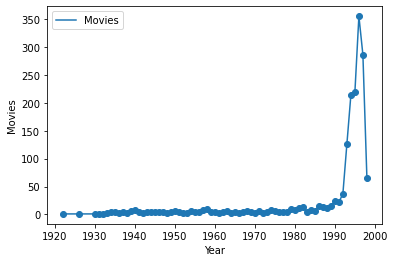

In [16]:
plt.plot(moviesByYear.keys().collect(), moviesByYear.values().collect(), label="Movies")
plt.scatter(moviesByYear.keys().collect(), moviesByYear.values().collect())
plt.xlabel("Year")
plt.ylabel("Movies")
plt.legend()
plt.show()

In [17]:
print("3.2- Number of movies year %s\n" % str(moviesByYear.filter(lambda i: i[0] == 1994).collect()[0]))

3.2- Number of movies year (1994, 214)



In [18]:
print("3.3- Maximum and Minimun movies/year: Max: %s | Min: %s\n" % (moviesByYear.max(lambda i: i[1]),moviesByYear.min(lambda i: i[1])))

3.3- Maximum and Minimun movies/year: Max: (1996, 355) | Min: (1922, 1)



In [19]:
print("3.5- Average movies/year: %s\n" % round(moviesByYear.values().mean(),4))

3.5- Average movies/year: 23.6761



In [20]:
print("3.6- Standard desviation movies/year: %s\n" % round(moviesByYear.values().stdev(),4))

3.6- Standard desviation movies/year: 63.5534



### Working with partitions

In [21]:
print("4.1- Num partitions: %s\n" % moviesByYear.getNumPartitions())

4.1- Num partitions: 2



In [22]:
moviesByYear = moviesByYear.repartition(10)
print("4.2 Num partitions: %s\n" % moviesByYear.getNumPartitions())

4.2 Num partitions: 10



# 3. Pair RDDs

In [23]:
# Get Data
data = sc.textFile("input/datasets/ml-100k/u.data").map(lambda i: [ word for word in i.split('\t')])

In [24]:
print("1.1- User ratings (user id, item id, rating, timestamp %s" % data.first())

1.1- User ratings (user id, item id, rating, timestamp ['196', '242', '3', '881250949']


In [25]:
data = data.map(lambda i: (int(i[0]), float(i[2]), int(i[1])))
movies = data
print("1.2- Numerical user ratings: ",data.first())

1.2- Numerical user ratings:  (196, 3.0, 242)


In [26]:
data = data.map(lambda i: (i[0], (i[1], i[2])))
print("2- Pair RDD: %s" % str(data.first()))

2- Pair RDD: (196, (3.0, 242))


In [27]:
seqOp  = (lambda acc, val: (acc[0]+val[0], acc[1]+1))
combOp = (lambda acc1, acc2: (acc1[0]+acc2[0], acc1[1]+acc2[1]))
data = data.aggregateByKey((0.0,0.0), seqOp, combOp)
print("3- Agregate user ratings and movies ((user id, (rating sum, number of movies)): %s" % data.takeOrdered(5,lambda i:i[0]))

3- Agregate user ratings and movies ((user id, (rating sum, number of movies)): [(1, (982.0, 272.0)), (2, (230.0, 62.0)), (3, (151.0, 54.0)), (4, (104.0, 24.0)), (5, (503.0, 175.0))]


In [28]:
data = data.mapValues(lambda i: (i[0]/i[1]))
print("4- User average ratings ((user id, rating sum/number of movies): %s" % data.takeOrdered(5,lambda i:i[0]))

4- User average ratings ((user id, rating sum/number of movies): [(1, 3.610294117647059), (2, 3.7096774193548385), (3, 2.7962962962962963), (4, 4.333333333333333), (5, 2.874285714285714)]


In [29]:
data = movies.map(lambda i : (i[2], 1)).reduceByKey(lambda a,b: a+b)
aux1 = data
print("5- Movie number of ratings (movie id, ratings number): %s " % data.takeOrdered(5,lambda i:i[0]))

5- Movie number of ratings (movie id, ratings number): [(1, 452), (2, 131), (3, 90), (4, 209), (5, 86)] 


In [30]:
data = movies.map(lambda i : (i[2], i[1])).filter(lambda i : i[1] > 3).map(lambda i : (i[0], 1)).reduceByKey(lambda a,b: a+b)
aux2 = data
print("6- High rating movies (movie id, high ratings number): %s" % data.takeOrdered(5,lambda i:i[0]))

6- High rating movies (movie id, high ratings number): [(1, 321), (2, 51), (3, 34), (4, 122), (5, 39)]


In [31]:
print("7- Top 5 rating movies: %s" % aux2.takeOrdered(5, lambda t: -t[1]))
print("7- Last 5 rating movies: %s" % aux2.takeOrdered(5, lambda t: t[1]))

7- Top 5 rating movies: [(50, 501), (100, 406), (181, 379), (127, 351), (174, 348)]
7- Last 5 rating movies: [(1186, 1), (1376, 1), (1492, 1), (1464, 1), (1306, 1)]


In [32]:
print("8- Movie rating counts dataset (movie id, ratings number): %s" % aux1.takeOrdered(5,lambda i:i[0]))
print("8- High rating movies dataset (movie id, high ratings number): %s" % aux2.takeOrdered(5,lambda i:i[0]))

data = aux1.leftOuterJoin(aux2)
print ("8- Join (movie id, (ratings number, high ratings number): %s" % data.takeOrdered(5,lambda i:i[0]))

8- Movie rating counts dataset (movie id, ratings number): [(1, 452), (2, 131), (3, 90), (4, 209), (5, 86)]
8- High rating movies dataset (movie id, high ratings number): [(1, 321), (2, 51), (3, 34), (4, 122), (5, 39)]
8- Join (movie id, (ratings number, high ratings number): [(1, (452, 321)), (2, (131, 51)), (3, (90, 34)), (4, (209, 122)), (5, (86, 39))]


In [33]:
print ("9- Info for movie id 314: %s" % data.filter(lambda i: i[0] == 314).collect())

9- Info for movie id 314: [(314, (5, None))]


In [34]:
data = data.mapValues(lambda i: 0 if i[0] == None or i[1] == None else i[1]/i[0])
print("9- Top higher rates movie (movie id, (high ratings number/ ratings number): %s" % data.takeOrdered(10, lambda x: (-x[1],x[0])))

9- Top higher rates movie (movie id, (high ratings number/ ratings number): [(711, 1.0), (814, 1.0), (1064, 1.0), (1080, 1.0), (1122, 1.0), (1125, 1.0), (1130, 1.0), (1189, 1.0), (1201, 1.0), (1235, 1.0)]
